## Parameter Tuning for KNN and RandomForest

In [2]:
import requests, time, operator, re, json, csv, pickle, copy, random
import pandas as pd
import numpy as np
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
train_path = '/data/2/zwang/2018_S_WordTreatment/Data/train/'
eval_path = '/data/2/zwang/2018_S_WordTreatment/Data/eval/'
wd_path = '/data/2/zwang/2018_S_WordTreatment/Data/crime/'

/home/zwang/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/zwang/.local/lib/python3.4/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Generate labeled sentences

#### only use training set

In [72]:
def get_labeled_sents(sents_file,label_file):
    sents_pd = pd.DataFrame(pickle.load(open(sents_file,'rb')))
    print(sents_pd.shape)
    all_sents = []
    all_labels = []
    for idx,row in sents_pd.iterrows():
        all_sents.extend(row['overview_sentences'])
        if(row['hood_crime'] <= row['city_crime']):
            all_labels.extend(np.ones(len(row['overview_sentences'])))
        elif(row['hood_crime'] > row['city_crime']):
            all_labels.extend(np.zeros(len(row['overview_sentences'])))
        
    
    pickle.dump({'sentences':all_sents,'labels':all_labels},open(label_file,'wb'))
    return all_sents,all_labels

In [74]:
train_sents,train_labels = get_labeled_sents(sents_file = train_path + 'onefold/city_hood_sents_train.pickle',
                                         label_file = train_path + 'onefold/sentences_labels_train.pickle')

(691, 5)


In [76]:
labeled_sents_train = pd.DataFrame(pickle.load(open(train_path + 'onefold/sentences_labels_train.pickle','rb')))

In [77]:
print(len(train_sents))

97286


In [78]:
Counter(train_labels)

Counter({0.0: 18282, 1.0: 79004})

#### Use training and evaluation set

In [79]:
eval_sents,eval_labels = get_labeled_sents(sents_file = eval_path + 'city_hood_sents_eval.pickle',
                                           label_file = eval_path + 'sentences_labels_eval.pickle')

(691, 5)


In [80]:
print(len(eval_sents))

96819


In [81]:
Counter(eval_labels)

Counter({0.0: 18124, 1.0: 78695})

In [82]:
labeled_sents_eval = pd.DataFrame(pickle.load(open(eval_path + 'sentences_labels_eval.pickle','rb')))

In [90]:
all_sents = []
all_labels = []
all_sents = labeled_sents_train['sentences'].values.tolist() + labeled_sents_eval['sentences'].values.tolist()
all_labels = labeled_sents_train['labels'].values.tolist() + labeled_sents_eval['labels'].values.tolist()

pickle.dump({'sentences':all_sents,'labels':all_labels},open(train_path + 'twofold/sentences_labels.pickle','wb'))

In [91]:
print(len(all_sents))

194105


In [92]:
Counter(all_labels)

Counter({0.0: 36406, 1.0: 157699})

### Parameter tunning for KNN classifier

In [94]:
def knn_tuning(labeled_sents_file,result_file,pipeline,params,nfolds):
    labeled_sents_pd = pd.DataFrame(pickle.load(open(labeled_sents_file,'rb')))
    print(labeled_sents_pd.shape,labeled_sents_pd.columns)
    
    all_train_sents = labeled_sents_pd['sentences']
    all_train_labels = labeled_sents_pd['labels']
    result = []
    
    skf = StratifiedKFold(n_splits=nfolds, random_state=42)
    for train_index, test_index in skf.split(all_train_sents, all_train_labels):
        print(len(test_index))
        train_sents = []
        train_labels = []
        for idx in test_index:
            train_sents.append(all_train_sents[idx])
            train_labels.append(all_train_labels[idx])
    
        gsearch = GridSearchCV(pipeline, param_grid = params, scoring='roc_auc', cv=10, n_jobs=-1)
        gsearch.fit(train_sents,train_labels)
        result.append({'grid_score':gsearch.grid_scores_,'best_param':gsearch.best_params_,'best_score':gsearch.best_score_})
        
    pickle.dump(result,open(result_file,'wb'))
    return result

In [10]:
pipeline = Pipeline([
    ('ctvec', CountVectorizer()),
    ('clf', KNeighborsClassifier())
])
parameters = {
        'ctvec__min_df' : (2,3,5),
        'ctvec__max_df' : (0.8,0.9,1.0),
        'clf__n_neighbors' : [5,10,30,50,100]
}

#### tuning for train data

In [11]:
start = time.time()
gsearch3_result = knn_tuning(train_path +'onefold/sentences_labels_train.pickle',train_path +'onefold/knn_tuning_result.pickle',pipeline,parameters,nfolds=3)
end = time.time()
print(end-start)

(97286, 2) Index(['labels', 'sentences'], dtype='object')
32429
32429
32428
1291.7940652370453


In [27]:
def plot_result(gsearch_result):
    # The order of the param sets do not change.
    param_set = []
    for param in gsearch_result[0]['grid_score']:
        param_set.append(param[0])
    mean = []
    for each_fold in gsearch_result:
        fold_mean = []
        for each_set in each_fold['grid_score']:
            fold_mean.append(each_set[1])
        mean.append(fold_mean)
    param_set_mean = np.mean(np.array(mean), axis = 0)
    j = 0
    for i in np.argsort(param_set_mean):
        print(j,param_set[i],param_set_mean[i])
        j += 1
    plt.plot(sorted(param_set_mean),'-ro')
    plt.xlabel("parameter set")
    plt.ylabel("mean roc_auc score")
    #break
#plot_result(gsearch3_result)

#### tuning for train+eval

In [95]:
start = time.time()
gsearch5_result = knn_tuning(train_path +'twofold/sentences_labels.pickle',train_path +'twofold/knn_tuning_result.pickle',pipeline,parameters,nfolds=5)
end = time.time()
print(end-start)

(194105, 2) Index(['labels', 'sentences'], dtype='object')
38822
38821
38821
38821
38820
3074.709460258484


In [104]:
gsearch5_result[0]['grid_score']

[mean: 0.58471, std: 0.05463, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 0.8, 'ctvec__min_df': 2},
 mean: 0.58186, std: 0.05511, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 0.8, 'ctvec__min_df': 3},
 mean: 0.58327, std: 0.05536, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 0.8, 'ctvec__min_df': 5},
 mean: 0.58471, std: 0.05463, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 0.9, 'ctvec__min_df': 2},
 mean: 0.58186, std: 0.05511, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 0.9, 'ctvec__min_df': 3},
 mean: 0.58327, std: 0.05536, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 0.9, 'ctvec__min_df': 5},
 mean: 0.58471, std: 0.05463, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 1.0, 'ctvec__min_df': 2},
 mean: 0.58186, std: 0.05511, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 1.0, 'ctvec__min_df': 3},
 mean: 0.58327, std: 0.05536, params: {'clf__n_neighbors': 5, 'ctvec__max_df': 1.0, 'ctvec__min_df': 5},
 mean: 0.59470, std: 0.05851, params: {'clf__n_neighbor

0 {'clf__n_neighbors': 5, 'ctvec__max_df': 0.8, 'ctvec__min_df': 3} 0.558363167203
1 {'clf__n_neighbors': 5, 'ctvec__max_df': 0.9, 'ctvec__min_df': 3} 0.558363167203
2 {'clf__n_neighbors': 5, 'ctvec__max_df': 1.0, 'ctvec__min_df': 3} 0.558363167203
3 {'clf__n_neighbors': 5, 'ctvec__max_df': 0.8, 'ctvec__min_df': 2} 0.560579586371
4 {'clf__n_neighbors': 5, 'ctvec__max_df': 0.9, 'ctvec__min_df': 2} 0.560579586371
5 {'clf__n_neighbors': 5, 'ctvec__max_df': 1.0, 'ctvec__min_df': 2} 0.560579586371
6 {'clf__n_neighbors': 5, 'ctvec__max_df': 0.8, 'ctvec__min_df': 5} 0.560915904642
7 {'clf__n_neighbors': 5, 'ctvec__max_df': 0.9, 'ctvec__min_df': 5} 0.560915904642
8 {'clf__n_neighbors': 5, 'ctvec__max_df': 1.0, 'ctvec__min_df': 5} 0.560915904642
9 {'clf__n_neighbors': 10, 'ctvec__max_df': 1.0, 'ctvec__min_df': 3} 0.564006623942
10 {'clf__n_neighbors': 10, 'ctvec__max_df': 0.9, 'ctvec__min_df': 3} 0.564006623942
11 {'clf__n_neighbors': 10, 'ctvec__max_df': 0.8, 'ctvec__min_df': 3} 0.564006623942

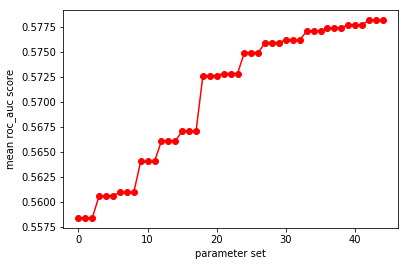

In [105]:
plot_result(gsearch5_result)

### Parameter tuning for RandomForest classifier

In [119]:
def get_rand_wds(wd_file,rand_wd_file):
    vocab = pd.read_csv(wd_file).word.values
    rand_idx = random.sample(range(len(vocab)),100)
    sel_words = []
    for idx in rand_idx:
        sel_words.append(vocab[idx])
    
    #pickle.dump(sel_words,open(rand_wd_file,'wb'))
    return sel_words

In [120]:
rand_wds = get_rand_wds(wd_file = wd_path + 'wd_paraphrase_xxxl.csv',rand_wd_file = wd_path +'random_100wds.pickle')

In [122]:
len(rand_wds)

100

In [126]:
test.head()

,neg_sents,pos_sents,word
0,[You'll be one block from bars and restaurants...,[The Hawthorne area is a 10 minute walk north....,10
1,"[Good bars down the road (see guidebook), the ...","[The Hawthorne District, 12 blocks away, offer...",12
2,[We are a 15 minute direct bus ride to downtow...,[A 15 cart food court - including Vietnamese a...,15
3,[It stretches about 20 blocks long and has Por...,[A majority of the other sights and natural la...,20
4,"[We live in a very walkable, safe, bike-able a...",[The Evermore Guesthouse is located in the the...,able


In [4]:
rand_wd_file = "/data/2/zwang/2018_S_WordTreatment/random_100wds.pickle"
rand_wd = pd.DataFrame(pickle.load(open(rand_wd_file,'rb')))

In [8]:
rand_wd[0].values

array(['cool', 'wild', 'various', 'able', 'choose', 'extremely',
       'downtown', 'etc', 'very', 'climbing', 'mere', 'strong', 'hub',
       'goods', 'opinion', 'yard', 'bite', 'southern', 'feeling', 'shop',
       'drink', 'sit', 'boutique', 'theatre', 'completely', 'feature',
       'fully', 'laundry', 'sure', 'peaceful', 'largest', 'birds',
       'tranquil', 'recommendations', 'distance', 'famous', 'experiences',
       'neighboring', 'often', 'favorite', 'months', 'theatres', 'were',
       'hospital', 'walk', 'neighborhoods', 'festivals', 'busy', 'needs',
       'chain', 'artists', 'relaxing', 'has', 'same', 'funky', 'prepared',
       'football', 'brew', 'general', 'ask', 'activity', 'done', 'nicest',
       'large', 'which', 'exercise', '20', 'ride', 'outdoor', 'plaza',
       'excellent', 'family', 'nearly', 'the', 'menus', 'ethnic',
       'anything', 'art', 'wide', 'cook', 'following', 'housing', 'how',
       'community', 'like', 'mixed', 'seeing', 'own', 'amenities', 'mo

In [22]:
def RFC_tuning(rand_wd_file,wd_sents_file,result_file,my_pipeline, my_params, nfold):
    rand_wd = pd.DataFrame(pickle.load(open(rand_wd_file,'rb')))[0].values
    sents_pd = pd.DataFrame(pickle.load(open(wd_sents_file,'rb')))
    
    result = []
    for wd in rand_wd:
        wdsents_pd = sents_pd[sents_pd['word'] == wd]
        wd_sents = wdsents_pd['pos_sents'].values[0] + wdsents_pd['neg_sents'].values[0]
        labels = list(np.ones(len(wdsents_pd['pos_sents'].values[0])))+list(np.zeros(len(wdsents_pd['neg_sents'].values[0])))
        print(wd,Counter(labels))
        if(len(wd_sents)>10000 or (min(Counter(labels)[0],Counter(labels)[1])/nfold)<1):
            continue
        gsearch = GridSearchCV(my_pipeline, my_params, scoring='roc_auc', cv=nfold, n_jobs = -1)
        gsearch.fit(wd_sents,labels)
        result.append({'grid_score':gsearch.grid_scores_,'best_param':gsearch.best_params_,'best_score':gsearch.best_score_})
    pickle.dump(result,open(result_file,'wb'))
    return result

#### tuning forest parameters

In [23]:
forest_pipeline = Pipeline([
    ('ctvec', CountVectorizer(min_df=2, max_df=0.8)),
    ('clf', RandomForestClassifier(oob_score=True, random_state=42,n_jobs=-1))
     ])
    
forest_params = {
        #'clf__max_features': ('sqrt','log2',None),
        #'clf__min_samples_leaf':(1,2,5,10),
        'clf__n_estimators' : (10,100,200,500,1000)
        }

In [24]:
start = time.time()
rand_wd_file = "/data/2/zwang/2018_S_WordTreatment/random_100wds.pickle"
wd_sents_file = "/data/2/zwang/2018_S_WordTreatment/wd_labeled_sentences.pickle"
result_file = "/data/2/zwang/2018_S_WordTreatment/RF_tuning_forest_result.pickle"
RFC_result = RFC_tuning(rand_wd_file,wd_sents_file,result_file,forest_pipeline, forest_params,nfold=10)
end = time.time()
print(end-start)

cool Counter({1.0: 650, 0.0: 185})
wild Counter({1.0: 53, 0.0: 12})
various Counter({1.0: 138, 0.0: 45})
able Counter({1.0: 158, 0.0: 40})
choose Counter({1.0: 166, 0.0: 33})
extremely Counter({1.0: 266, 0.0: 56})
downtown Counter({1.0: 3188, 0.0: 921})
etc Counter({1.0: 1242, 0.0: 282})
very Counter({1.0: 4341, 0.0: 1102})
climbing Counter({1.0: 27, 0.0: 10})
mere Counter({1.0: 71, 0.0: 10})
strong Counter({1.0: 59, 0.0: 19})
hub Counter({1.0: 176, 0.0: 30})
goods Counter({1.0: 64, 0.0: 12})
opinion Counter({1.0: 77, 0.0: 13})
yard Counter({1.0: 74, 0.0: 21})
bite Counter({1.0: 63, 0.0: 14})
southern Counter({1.0: 231, 0.0: 47})
feeling Counter({1.0: 137, 0.0: 32})
shop Counter({1.0: 1008, 0.0: 212})
drink Counter({1.0: 338, 0.0: 63})
sit Counter({1.0: 112, 0.0: 18})
boutique Counter({1.0: 341, 0.0: 44})
theatre Counter({1.0: 387, 0.0: 172})
completely Counter({1.0: 52, 0.0: 18})
feature Counter({1.0: 51, 0.0: 10})
fully Counter({1.0: 69, 0.0: 11})
laundry Counter({1.0: 279, 0.0: 65})

In [143]:
#9:58
print("yes")

yes


0 {'clf__n_estimators': 10} 0.525368834097
1 {'clf__n_estimators': 500} 0.538517380773
2 {'clf__n_estimators': 100} 0.539316500195
3 {'clf__n_estimators': 1000} 0.54017072385
4 {'clf__n_estimators': 200} 0.540968837337


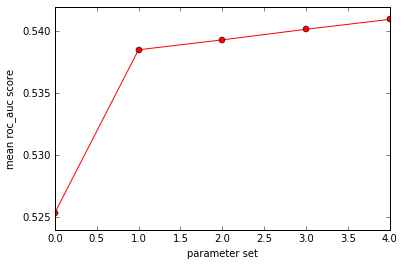

In [28]:
plot_result(RFC_result)

#### tuning tree parameters

In [29]:
tree_pipeline = Pipeline([
    ('ctvec', CountVectorizer(min_df=2, max_df=0.8)),
    ('clf', RandomForestClassifier(n_estimators=200 ,oob_score=True, 
                                   random_state=42,n_jobs=-1))
     ])
    
tree_params = {
        'clf__max_features': ('sqrt','log2',None),
        'clf__min_samples_leaf':(1,2,5,10)
        #'clf__n_estimators' : (10,100,200,500,1000)
        }

In [32]:
start = time.time()
rand_wd_file = "/data/2/zwang/2018_S_WordTreatment/random_100wds.pickle"
wd_sents_file = "/data/2/zwang/2018_S_WordTreatment/wd_labeled_sentences.pickle"
result_file = "/data/2/zwang/2018_S_WordTreatment/RF_tuning_tree_result.pickle"

RFC_tree_result = RFC_tuning(rand_wd_file,wd_sents_file,result_file,tree_pipeline, tree_params,nfold=10)
end = time.time()
print(end-start)

cool Counter({1.0: 650, 0.0: 185})
wild Counter({1.0: 53, 0.0: 12})
various Counter({1.0: 138, 0.0: 45})
able Counter({1.0: 158, 0.0: 40})
choose Counter({1.0: 166, 0.0: 33})
extremely Counter({1.0: 266, 0.0: 56})
downtown Counter({1.0: 3188, 0.0: 921})
etc Counter({1.0: 1242, 0.0: 282})
very Counter({1.0: 4341, 0.0: 1102})
climbing Counter({1.0: 27, 0.0: 10})
mere Counter({1.0: 71, 0.0: 10})
strong Counter({1.0: 59, 0.0: 19})
hub Counter({1.0: 176, 0.0: 30})
goods Counter({1.0: 64, 0.0: 12})
opinion Counter({1.0: 77, 0.0: 13})
yard Counter({1.0: 74, 0.0: 21})
bite Counter({1.0: 63, 0.0: 14})
southern Counter({1.0: 231, 0.0: 47})
feeling Counter({1.0: 137, 0.0: 32})
shop Counter({1.0: 1008, 0.0: 212})
drink Counter({1.0: 338, 0.0: 63})
sit Counter({1.0: 112, 0.0: 18})
boutique Counter({1.0: 341, 0.0: 44})
theatre Counter({1.0: 387, 0.0: 172})
completely Counter({1.0: 52, 0.0: 18})
feature Counter({1.0: 51, 0.0: 10})
fully Counter({1.0: 69, 0.0: 11})
laundry Counter({1.0: 279, 0.0: 65})

0 {'clf__max_features': None, 'clf__min_samples_leaf': 2} 0.537714441047
1 {'clf__max_features': None, 'clf__min_samples_leaf': 10} 0.537954798932
2 {'clf__max_features': None, 'clf__min_samples_leaf': 1} 0.538978384747
3 {'clf__max_features': 'log2', 'clf__min_samples_leaf': 10} 0.540154119709
4 {'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1} 0.540968837337
5 {'clf__max_features': None, 'clf__min_samples_leaf': 5} 0.541483890733
6 {'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2} 0.542757879268
7 {'clf__max_features': 'log2', 'clf__min_samples_leaf': 5} 0.543383594428
8 {'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5} 0.544755942971
9 {'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10} 0.544884587565
10 {'clf__max_features': 'log2', 'clf__min_samples_leaf': 1} 0.544978654379
11 {'clf__max_features': 'log2', 'clf__min_samples_leaf': 2} 0.546116166792


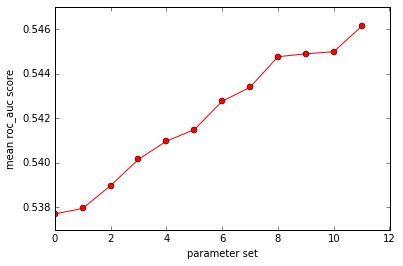

In [33]:
plot_result(RFC_tree_result)

#### tuning for training data

In [ ]:
train_sents_pd = pd.DataFrame(pickle.load(open(wd_sents_file,'rb')))

#### tuning for training_eval data